In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import yfinance as yf
from datetime import datetime
import datetime as dt

In [ ]:
def get_stock_data(ticker):
    """Fetching stock data and calculate volatility"""
    try:
        # Get stock data
        stock = yf.Ticker(ticker)
        hist = stock.history(period="1y")

        if hist.empty:
            raise ValueError(f"No data found for ticker {ticker}")

        # Calculating daily returns and volatility
        daily_returns = hist['Close'].pct_change()
        annual_volatility = daily_returns.std() * np.sqrt(252)

        current_price = hist['Close'].iloc[-1]
        risk_free_rate = get_risk_free_rate()

        return {
            'price': current_price,
            'volatility': annual_volatility,
            'risk_free_rate': risk_free_rate
        }
    except Exception as e:
        raise ValueError(f"Error fetching data for {ticker}: {str(e)}")

In [ ]:
def get_risk_free_rate():
    """Getting risk-free rate from 10-year Treasury yield (simplified)"""
    try:
        treasury = yf.Ticker("^TNX")
        current_yield = treasury.history(period="1d")['Close'].iloc[-1] / 100
        return current_yield
    except:
        print("Warning: Could not fetch risk-free rate. Using default value of 0.03 (3%)")
        return 0.03

In [ ]:
def calculate_time_to_expiry(expiry_date):
    """Calculating time to expiry in years"""
    try:
        if isinstance(expiry_date, str):
            expiry = datetime.strptime(expiry_date, '%Y-%m-%d')
        else:
            expiry = expiry_date

        today = datetime.now()
        days_to_expiry = (expiry - today).days

        if days_to_expiry < 0:
            raise ValueError("Expiration date must be in the future")

        return days_to_expiry / 365
    except ValueError as e:
        raise ValueError(f"Invalid date format. Please use YYYY-MM-DD format. Error: {str(e)}")

In [ ]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Calculating Black-Scholes option price and Greeks"""

    # Calculate d1 and d2
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    # Calculate option price
    if option_type.lower() == 'call':
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:  # Put option
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

    # Calculate greeks
    if option_type.lower() == 'call':
      delta = norm.cdf(d1)
      theta = (-S*sigma*norm.pdf(d1))/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2)
      gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))
      vega = S*norm.pdf(d1)*np.sqrt(T)
      rho = T*K*np.exp(-r*T)*norm.cdf(d2)

    else :
      delta = -norm.cdf(-d1)
      theta = (-S*sigma*norm.pdf(d1))/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2)
      gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))
      vega = S*norm.pdf(d1)*np.sqrt(T)
      rho = -T*K*np.exp(-r*T)*norm.cdf(-d2)

    return {
        'price': price,
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta,
        'rho': rho
    }



In [ ]:
def plot_option_value(S_range, K, T, r, sigma):
    """Ploting option values for a range of stock prices"""
    call_prices = []
    put_prices = []

    for S in S_range:
        call_result = black_scholes(S, K, T, r, sigma, 'call')
        put_result = black_scholes(S, K, T, r, sigma, 'put')
        call_prices.append(call_result['price'])
        put_prices.append(put_result['price'])

    plt.figure(figsize=(10, 6))
    plt.plot(S_range, call_prices, label='Call Option')
    plt.plot(S_range, put_prices, label='Put Option')
    plt.xlabel('Stock Price')
    plt.ylabel('Option Value')
    plt.title('Option Values vs Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_historical_volatility(ticker):
    """Ploting historical volatility"""
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")

    # Calculate rolling 30-day volatility
    returns = hist['Close'].pct_change()
    volatility = returns.rolling(window=30).std() * np.sqrt(252)

    plt.figure(figsize=(10, 6))
    plt.plot(volatility.index, volatility.values)
    plt.title(f'30-Day Rolling Volatility - {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.grid(True)
    plt.show()


Welcome to the Enhanced Black-Scholes Option Pricing Calculator!

Enter stock ticker symbol (e.g., AAPL): msft

Fetching data for MSFT...

Current stock price: $416.06
Historical volatility: 19.60%
Risk-free rate: 3.98%

Enter strike price: 410
Enter expiration date (YYYY-MM-DD): 2024-11-30
Time to expiry: 0.151 years
Enter option type (call/put): put

Results:
+----------+---------------+--------------+
| Metric   |   Call Option |   Put Option |
+==========+===============+==============+
| Price    |       17.2099 |       8.6978 |
+----------+---------------+--------------+
| Delta    |        0.6216 |      -0.3784 |
+----------+---------------+--------------+
| Gamma    |        0.012  |       0.012  |
+----------+---------------+--------------+
| Vega     |       61.414  |      61.414  |
+----------+---------------+--------------+
| Theta    |      -49.5499 |     -33.3255 |
+----------+---------------+--------------+
| Rho      |       36.3787 |     -25.0326 |
+----------+--------

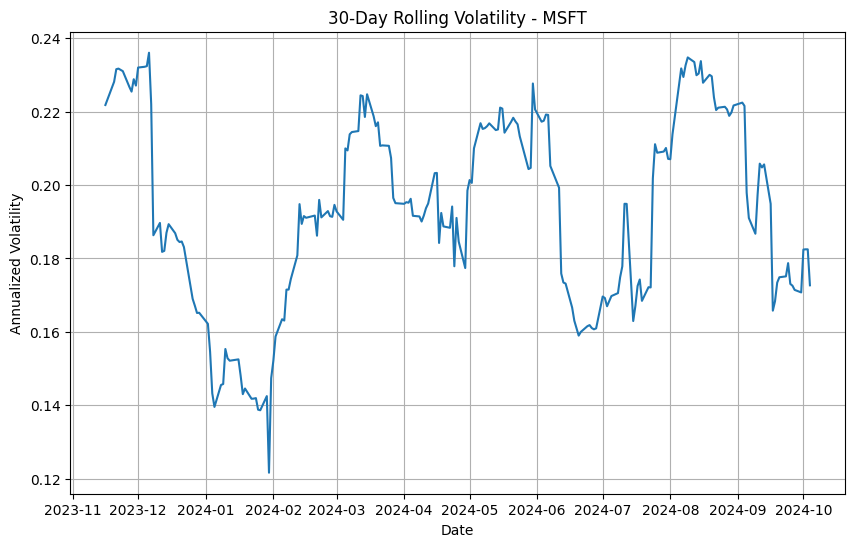

--------------------------------------------------------------------------------------


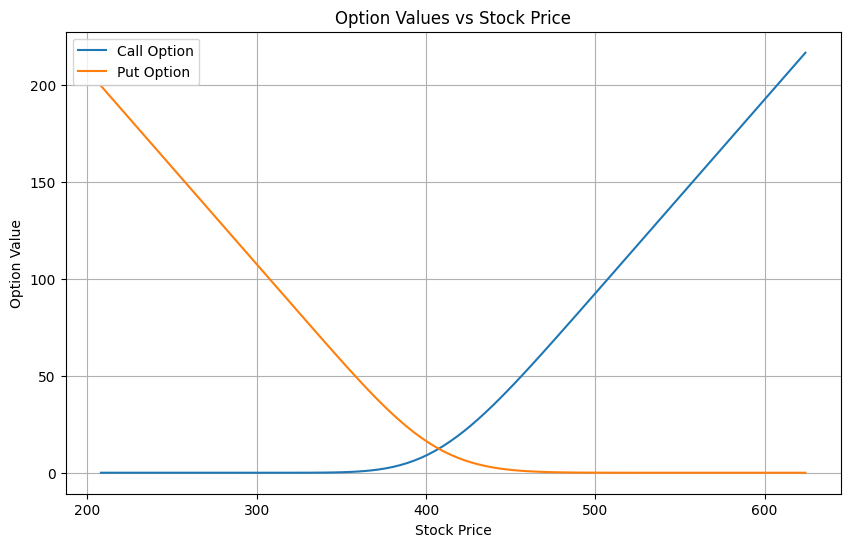


Calculate another option? (y/n): n


In [ ]:
def main():
    print("This is a Black-Scholes Option Pricing Calculator!")

    while True:
        try:
            # Get stock ticker and fetch data
            ticker = input("\nEnter stock ticker symbol (e.g., AAPL): ").upper()
            print(f"\nFetching data for {ticker}...")

            stock_data = get_stock_data(ticker)
            S = stock_data['price']
            sigma = stock_data['volatility']
            r = stock_data['risk_free_rate']

            print(f"\nCurrent stock price: ${S:.2f}")
            print(f"Historical volatility: {sigma:.2%}")
            print(f"Risk-free rate: {r:.2%}")

            # Plot historical volatility
            #plot_historical_volatility(ticker)

            # Get other parameters
            K = float(input("\nEnter strike price: "))
            expiry_date = input("Enter expiration date (YYYY-MM-DD): ")
            T = calculate_time_to_expiry(expiry_date)
            print(f"Time to expiry: {T:.3f} years")

            option_type = input("Enter option type (call/put): ").lower()

            if option_type not in ['call', 'put']:
                print("Invalid option type. Please enter 'call' or 'put'.")
                continue

            # Calculate results for both call and put
            results = {
                'call': black_scholes(S, K, T, r, sigma, 'call'),
                'put': black_scholes(S, K, T, r, sigma, 'put')
            }

            # Display results in a table
            headers = ['Metric', 'Call Option', 'Put Option']
            table_data = []
            for metric in ['price', 'delta', 'gamma', 'vega', 'theta', 'rho']:
                row = [
                    metric.capitalize(),
                    f"{results['call'][metric]:.4f}",
                    f"{results['put'][metric]:.4f}"
                ]
                table_data.append(row)

            print("\nResults:")
            print(tabulate(table_data, headers=headers, tablefmt='grid'))

            # Plot historical volatility
            plot_historical_volatility(ticker)

            print("----------------------------------------------------------------------------------------------------------------------------------")

            # Plot option values
            S_range = np.linspace(max(0.5*S, 1), 1.5*S, 100)
            plot_option_value(S_range, K, T, r, sigma)


            # Ask if user wants to continue
            if input("\nCalculate another option? (y/n): ").lower() != 'y':
                break

        except ValueError as e:
            print(f"Error: {str(e)}")
            continue
        except Exception as e:
            print(f"An unexpected error occurred: {str(e)}")
            continue

if __name__ == "__main__":
    main()